# 1. Import needed libraries

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, Input, InputLayer
from tensorflow.keras import regularizers
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [5]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('/content/drive/MyDrive/BTC/Dataset/Training')

In [7]:
ts_df = test_df('/content/drive/MyDrive/BTC/Dataset/Testing')

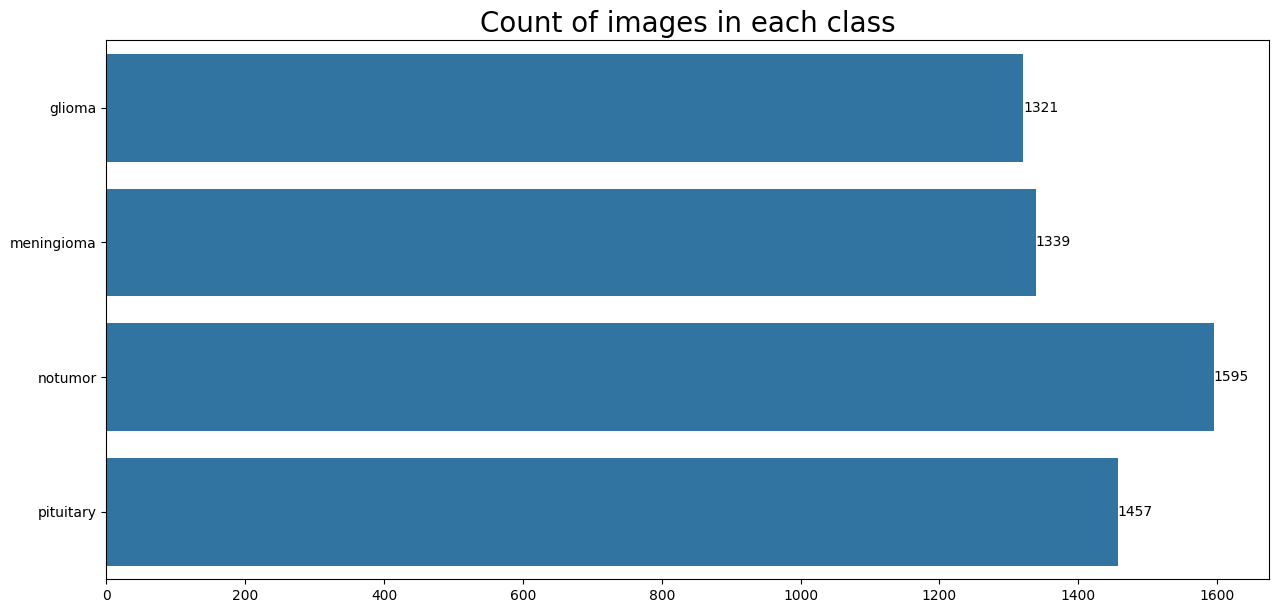

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

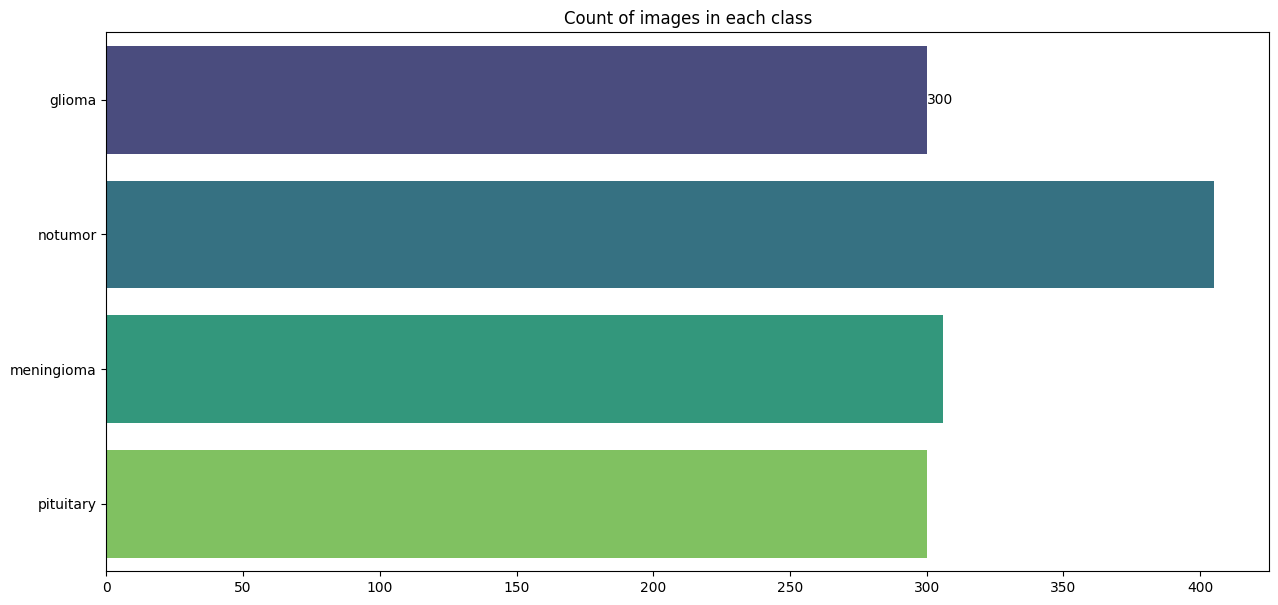

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

## 2.3 Data preprocessing

In [11]:
batch_size = 16
img_size = (512, 512)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

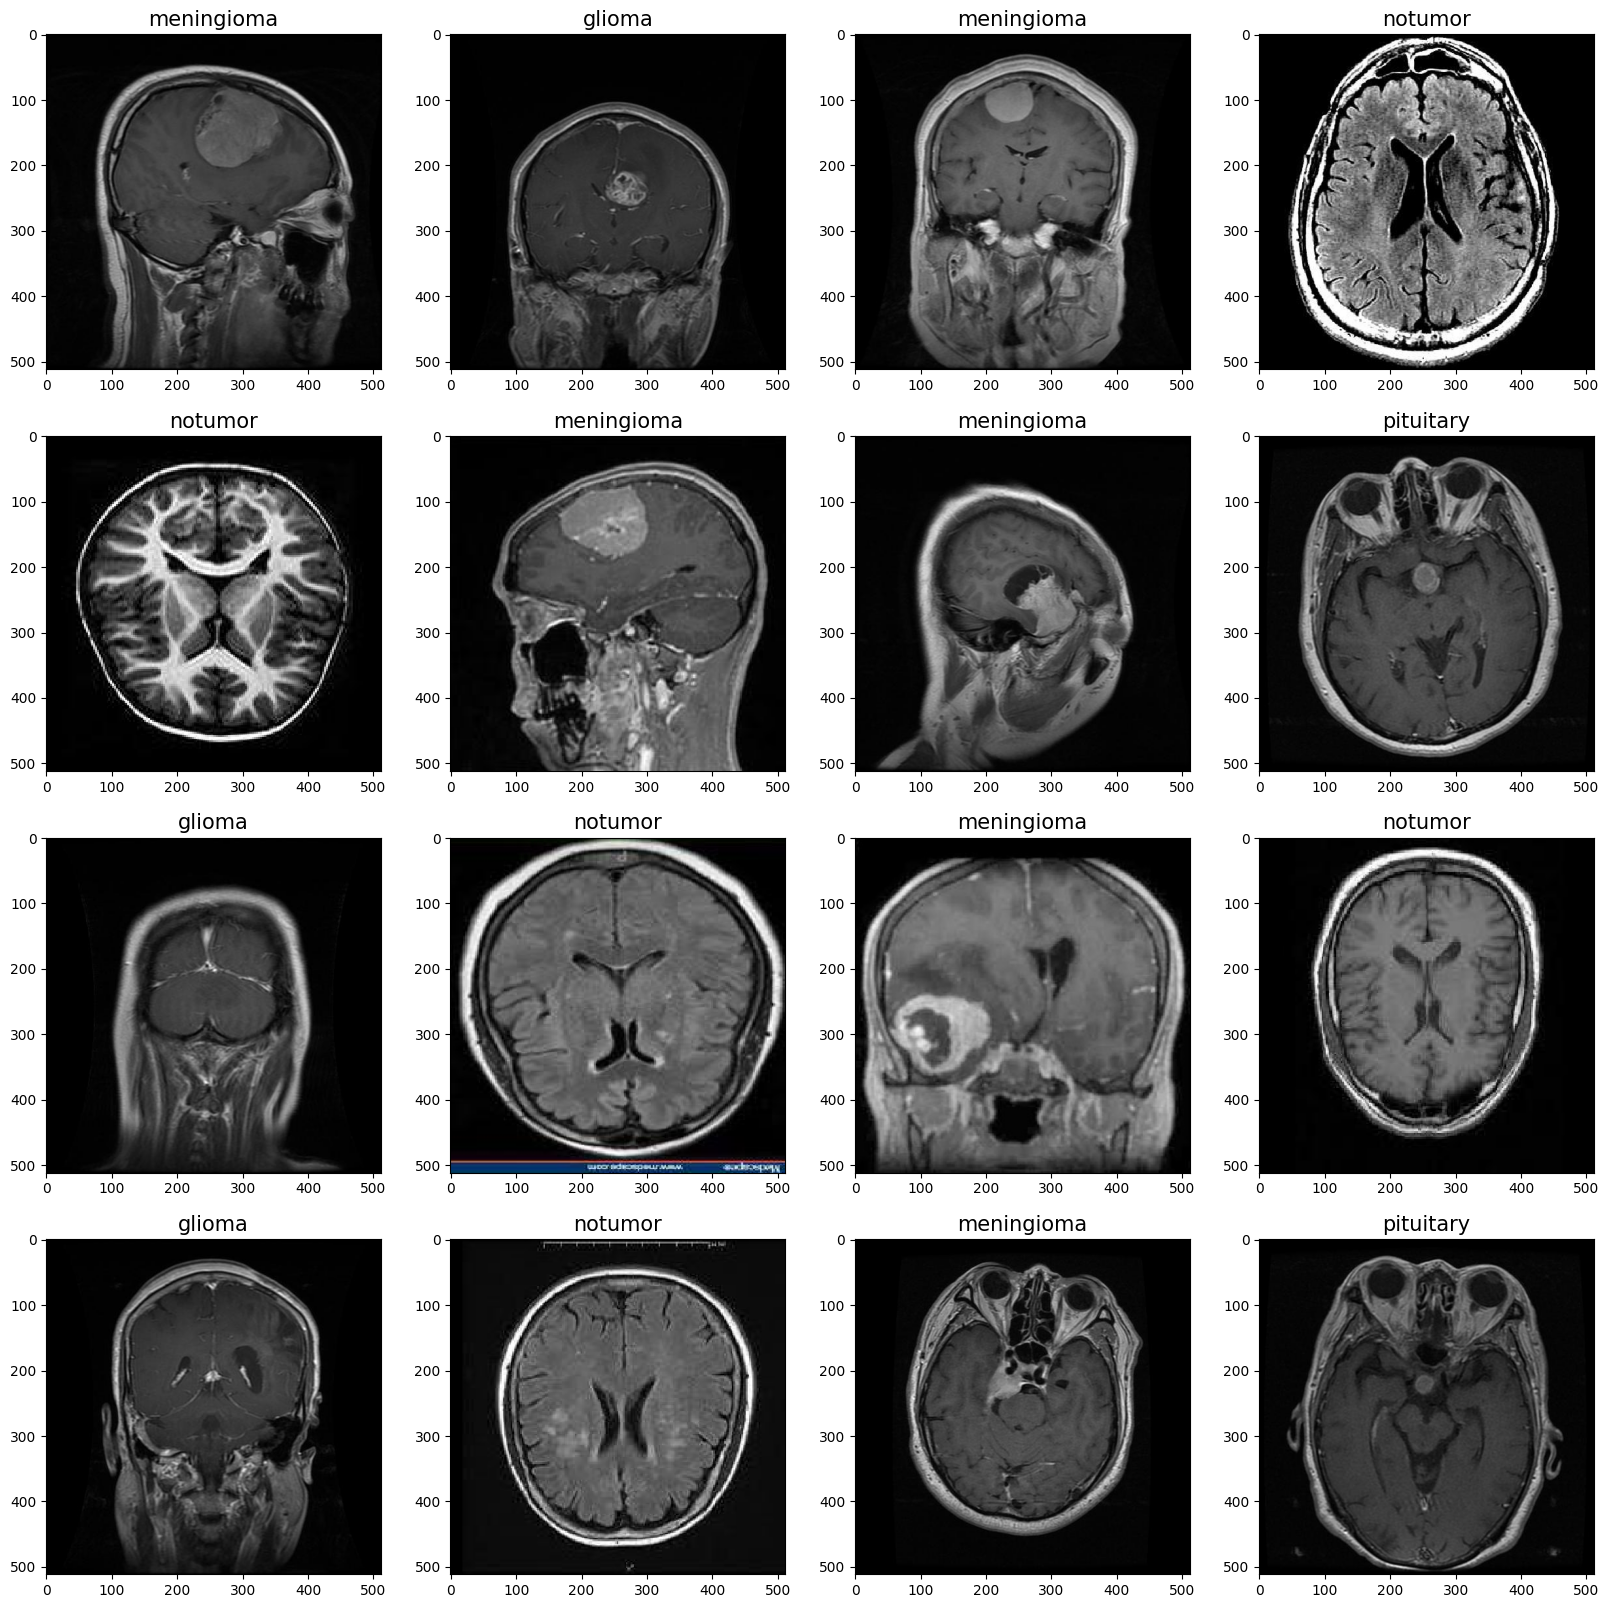

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [13]:
img_shape=(512,512,3)
model = Sequential()
model.add(InputLayer(input_shape=(512,512,3)))

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 508, 508, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 254, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 254, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 125, 125, 64)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 64)      0

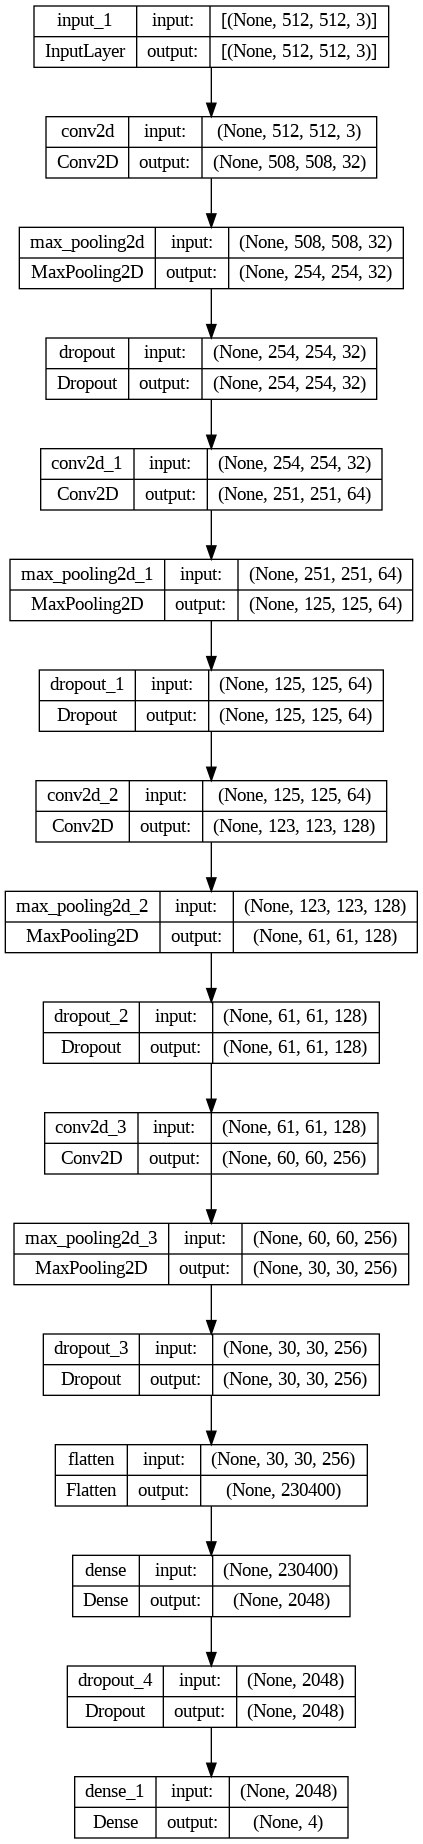

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [15]:
hist = model.fit(tr_gen,
                 epochs=20,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/20
357/357 [==============================] - 1317s 4s/step - loss: 0.8540 - accuracy: 0.6977 - precision: 0.7664 - recall: 0.6106 - val_loss: 0.6651 - val_accuracy: 0.7267 - val_precision: 0.7691 - val_recall: 0.6611
Epoch 2/20
357/357 [==============================] - 141s 393ms/step - loss: 0.4318 - accuracy: 0.8325 - precision: 0.8482 - recall: 0.8099 - val_loss: 0.4084 - val_accuracy: 0.8275 - val_precision: 0.8426 - val_recall: 0.8092
Epoch 3/20
357/357 [==============================] - 142s 397ms/step - loss: 0.2852 - accuracy: 0.8965 - precision: 0.9026 - recall: 0.8871 - val_loss: 0.4052 - val_accuracy: 0.8336 - val_precision: 0.8583 - val_recall: 0.8137
Epoch 4/20
357/357 [==============================] - 142s 397ms/step - loss: 0.1609 - accuracy: 0.9459 - precision: 0.9484 - recall: 0.9424 - val_loss: 0.2097 - val_accuracy: 0.9282 - val_precision: 0.9308 - val_recall: 0.9237
Epoch 5/20
357/357 [==============================] - 142s 396ms/step - loss: 0.1235 - acc

In [16]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

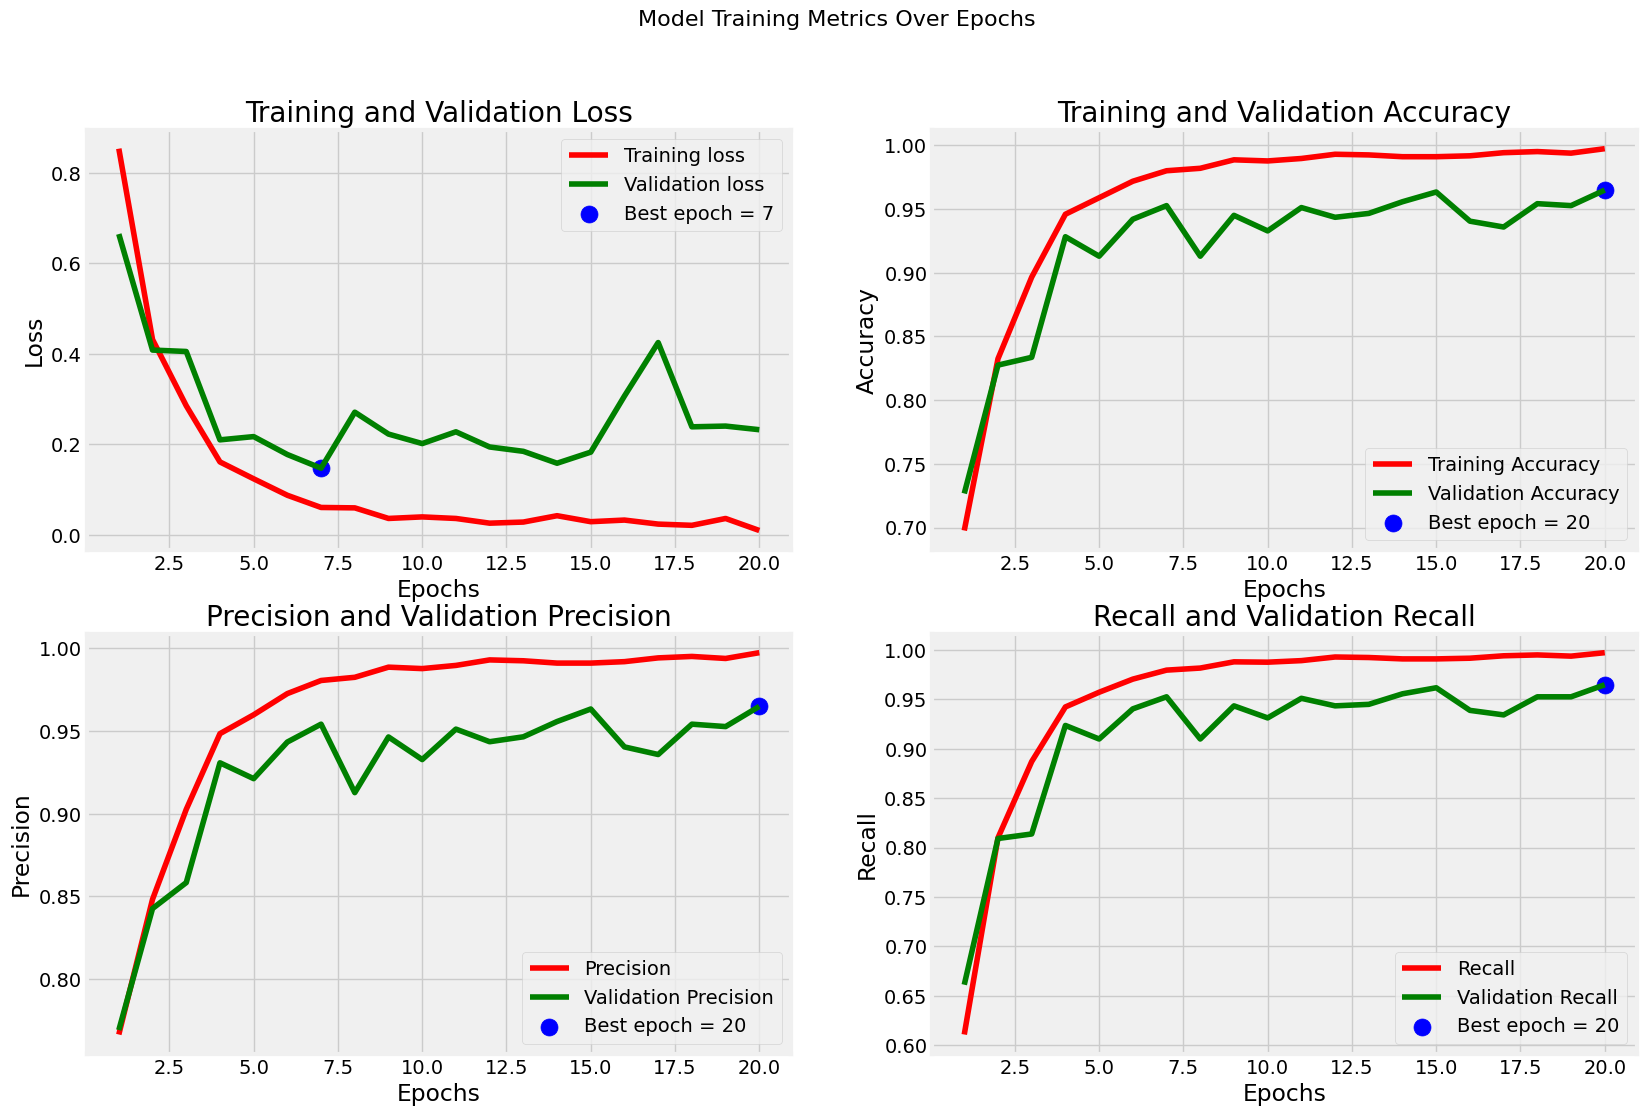

In [17]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('TV_Loss.png')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('TV_Acc.png')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig('TV_Loss.png')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [18]:
import numpy as np
import json

data = {
    "tr_acc": tr_acc,
    "tr_loss": tr_loss,
    "tr_per": tr_per,
    "tr_recall": tr_recall,
    "val_acc": val_acc,
    "val_loss": val_loss,
    "val_per": val_per,
    "val_recall": val_recall,
    "index_loss": int(index_loss),
    "val_lowest": float(val_lowest),
    "index_acc": int(index_acc),
    "acc_highest": float(acc_highest),
    "index_precision": int(index_precision),
    "per_highest": float(per_highest),
    "index_recall": int(index_recall),
    "recall_highest": float(recall_highest),
    "Epochs": Epochs,
    "loss_label": loss_label,
    "acc_label": acc_label,
    "per_label": per_label,
    "recall_label": recall_label
}

# Save data to a JSON file
with open('training_metrics.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

# 5. Testing and Evaluation

## 5.1 Evaluate

In [19]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


41/41 [==============================] - 104s 3s/step - loss: 0.4490 - accuracy: 0.9649 - precision: 0.9649 - recall: 0.9649
Train Loss: 0.0025
Train Accuracy: 99.91%
--------------------
Validation Loss: 0.2297
Validation Accuracy: 96.49%
--------------------
Test Loss: 0.4490
Test Accuracy: 96.49%


In [20]:
with open('model_scores.txt', 'w') as file:
    file.write("Train Loss: {}\n".format(train_score[0]))
    file.write("Train Accuracy: {}\n".format(train_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Validation Loss: {}\n".format(valid_score[0]))
    file.write("Validation Accuracy: {}\n".format(valid_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Test Loss: {}\n".format(test_score[0]))
    file.write("Test Accuracy: {}\n".format(test_score[1]))

print("Scores saved successfully.")

Scores saved successfully.


In [21]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 8s 199ms/step


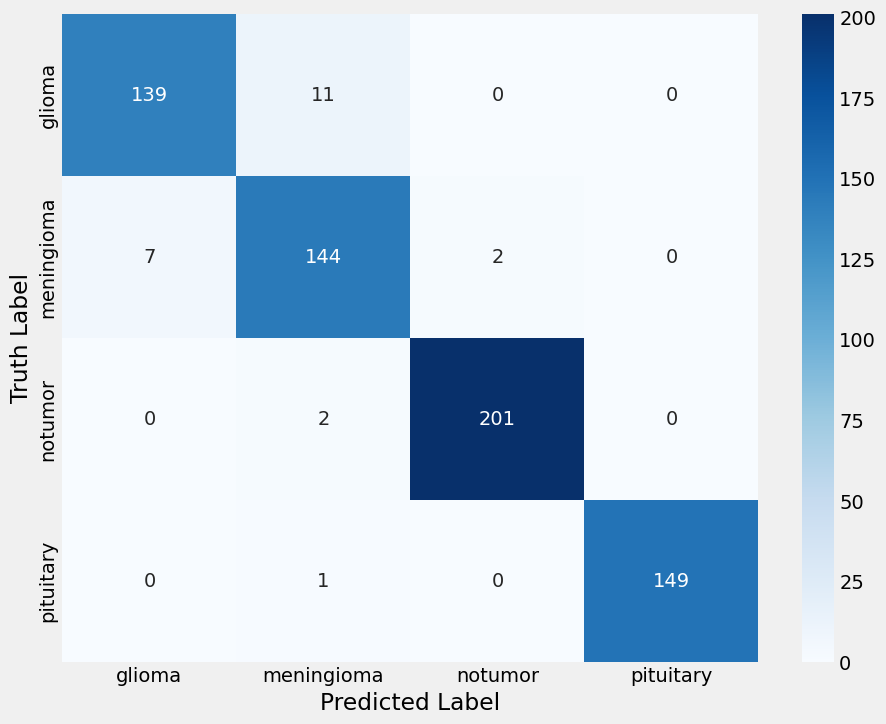

In [22]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.savefig('Confusion_Matrix.png')
plt.show()

In [23]:
import json
classes = list(ts_gen.class_indices.keys())
print(classification_report(ts_gen.classes, y_pred , target_names= classes ))

# Save the classification report to json
report = classification_report(ts_gen.classes, y_pred , target_names= classes , output_dict= True)
report_df = pd.DataFrame(report).transpose()
report_df.to_json('classification_report.json')

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       150
  meningioma       0.91      0.94      0.93       153
     notumor       0.99      0.99      0.99       203
   pituitary       1.00      0.99      1.00       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.96      0.97       656



In [24]:
precision = report_df['precision']
recall = report_df['recall']
f1_score = report_df['f1-score']
classes = report_df.index

# Calculate TPR and FPR for each class
tpr = recall
fpr = 1 - precision

# Save TPR and FPR to a DataFrame
tpr_fpr_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr}, index=classes)


tpr_fpr_json = tpr_fpr_df.to_json(orient='index')
print(tpr_fpr_df)
# Write JSON to file
with open('tpr_fpr.json', 'w') as f:
    json.dump(tpr_fpr_json, f)

print("TPR and FPR saved as JSON.")

                   TPR       FPR
glioma        0.926667  0.047945
meningioma    0.941176  0.088608
notumor       0.990148  0.009852
pituitary     0.993333  0.000000
accuracy      0.964939  0.035061
macro avg     0.962831  0.036601
weighted avg  0.964939  0.034678
TPR and FPR saved as JSON.


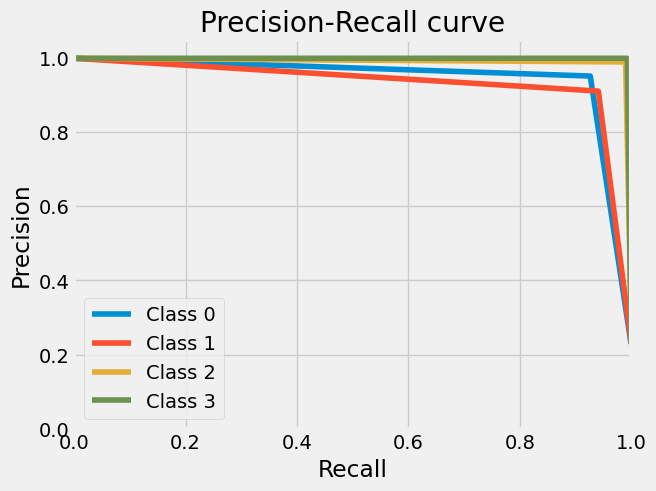

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have predictions (preds) and true labels (y_true) for your test set
num_classes = 4
# Get true labels from test_gen
y_true = np.array(ts_gen.classes)

# Binarize the predicted probabilities or scores
y_pred_binarized = label_binarize(y_pred, classes=range(num_classes))

# Calculate precision and recall for each class separately
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve((y_true == i).astype(int), y_pred_binarized[:, i])
    plt.plot(recall[i], precision[i], label='Class {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('precision_recall_curve_multiclass.png')
plt.show()


## 5.2 Testing

In [26]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((512, 512))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 1s 1s/step


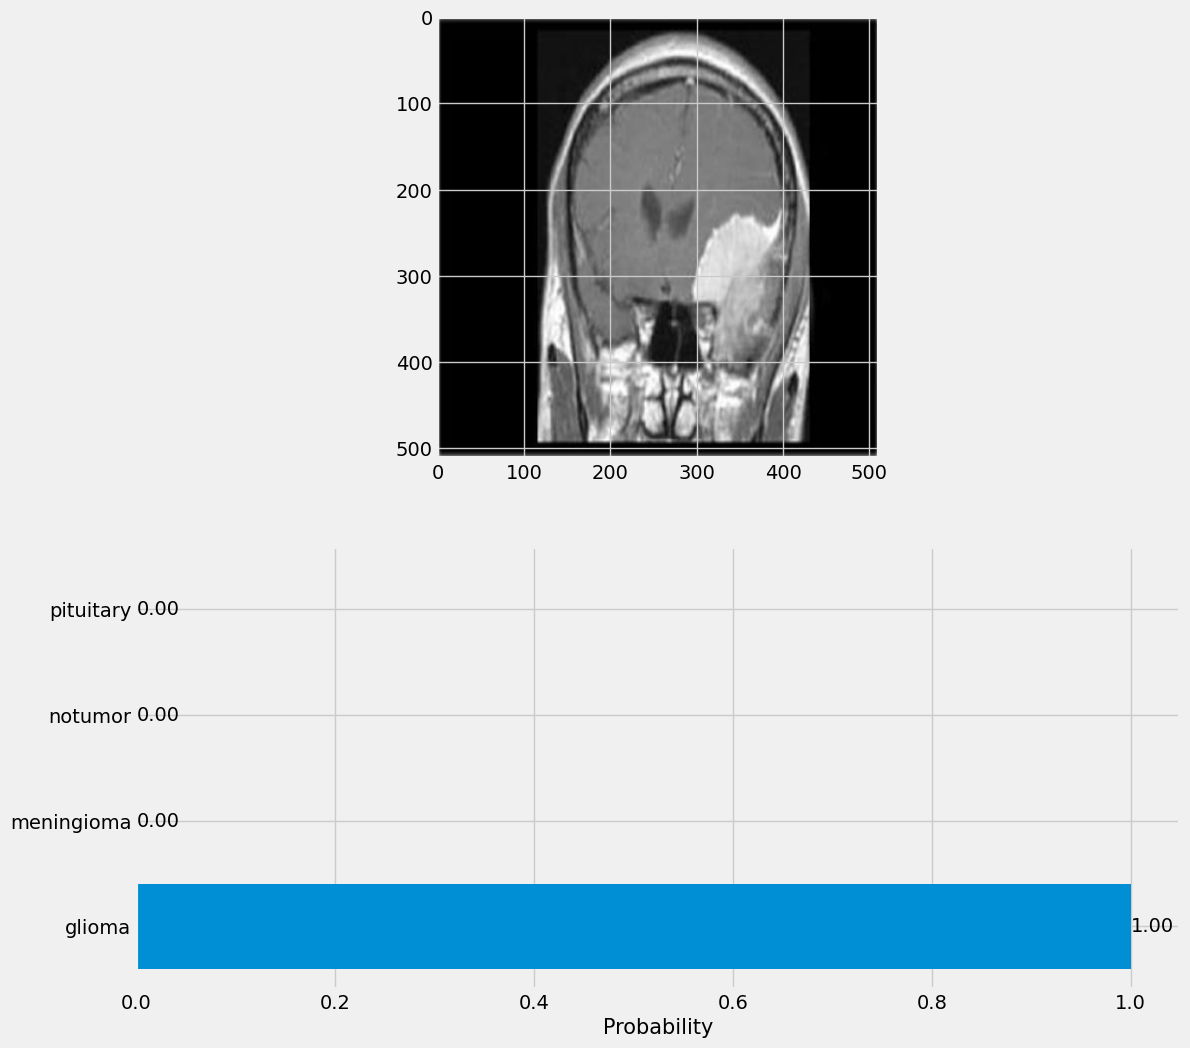

In [28]:
predict('/content/drive/MyDrive/BTC/Dataset/Testing/meningioma/Te-meTr_0000.jpg')

1/1 [==============================] - 0s 20ms/step


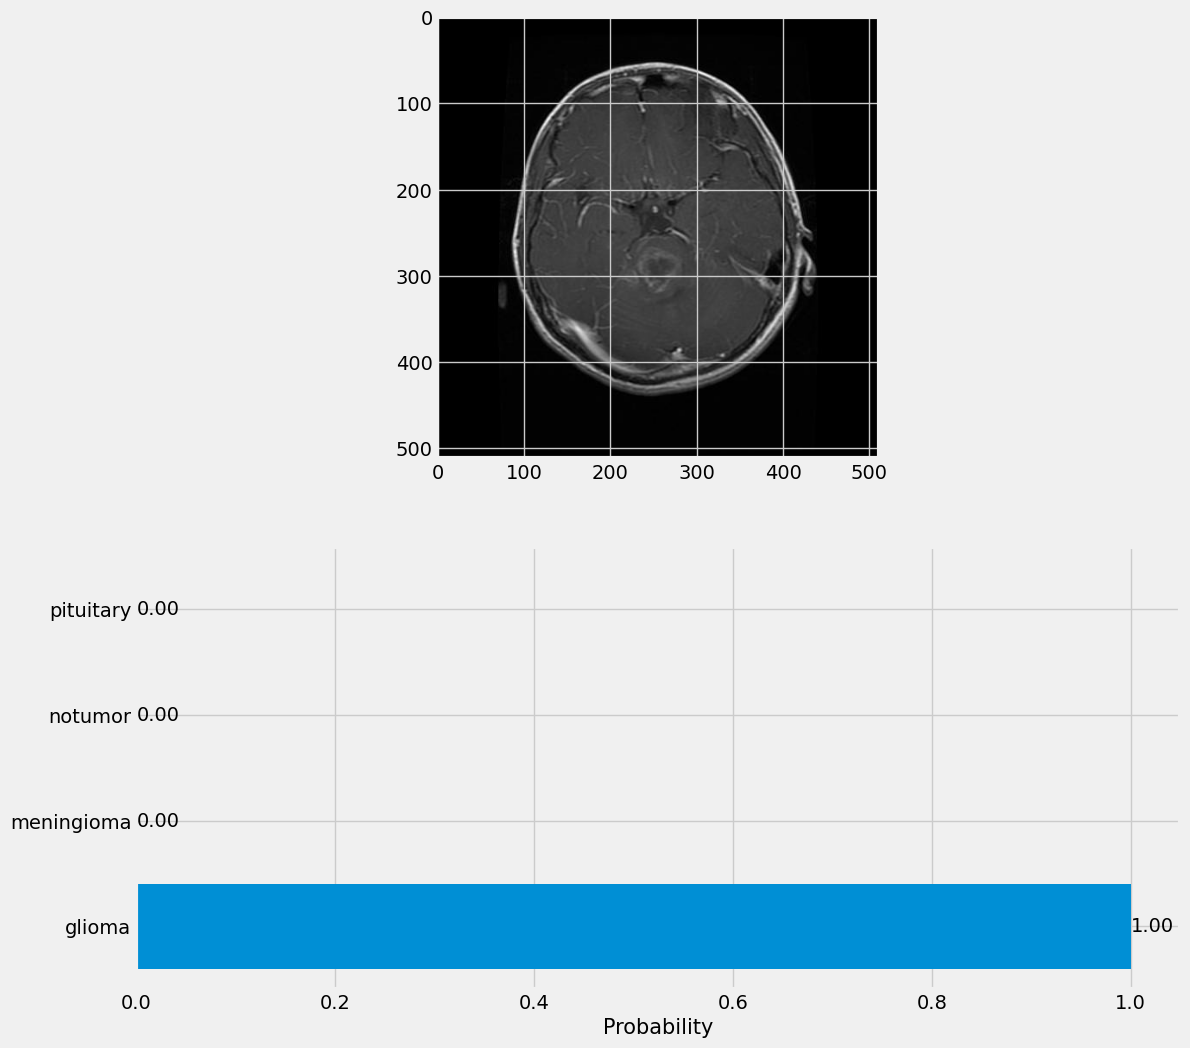

In [29]:
predict('/content/drive/MyDrive/BTC/Dataset/Testing/glioma/Te-glTr_0007.jpg')

1/1 [==============================] - 0s 21ms/step


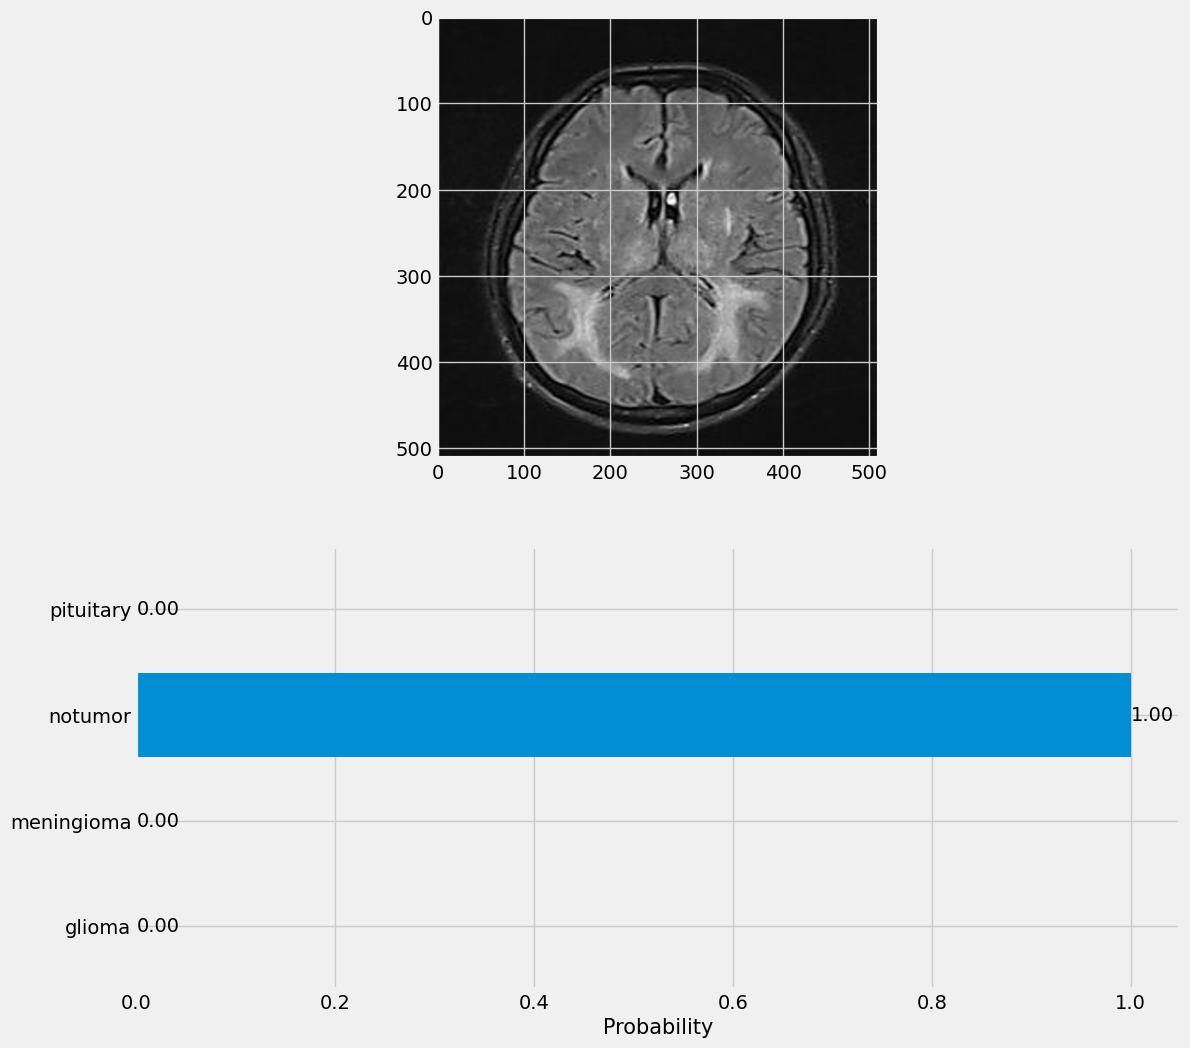

In [30]:
predict('/content/drive/MyDrive/BTC/Dataset/Testing/notumor/Te-noTr_0001.jpg')

1/1 [==============================] - 0s 19ms/step


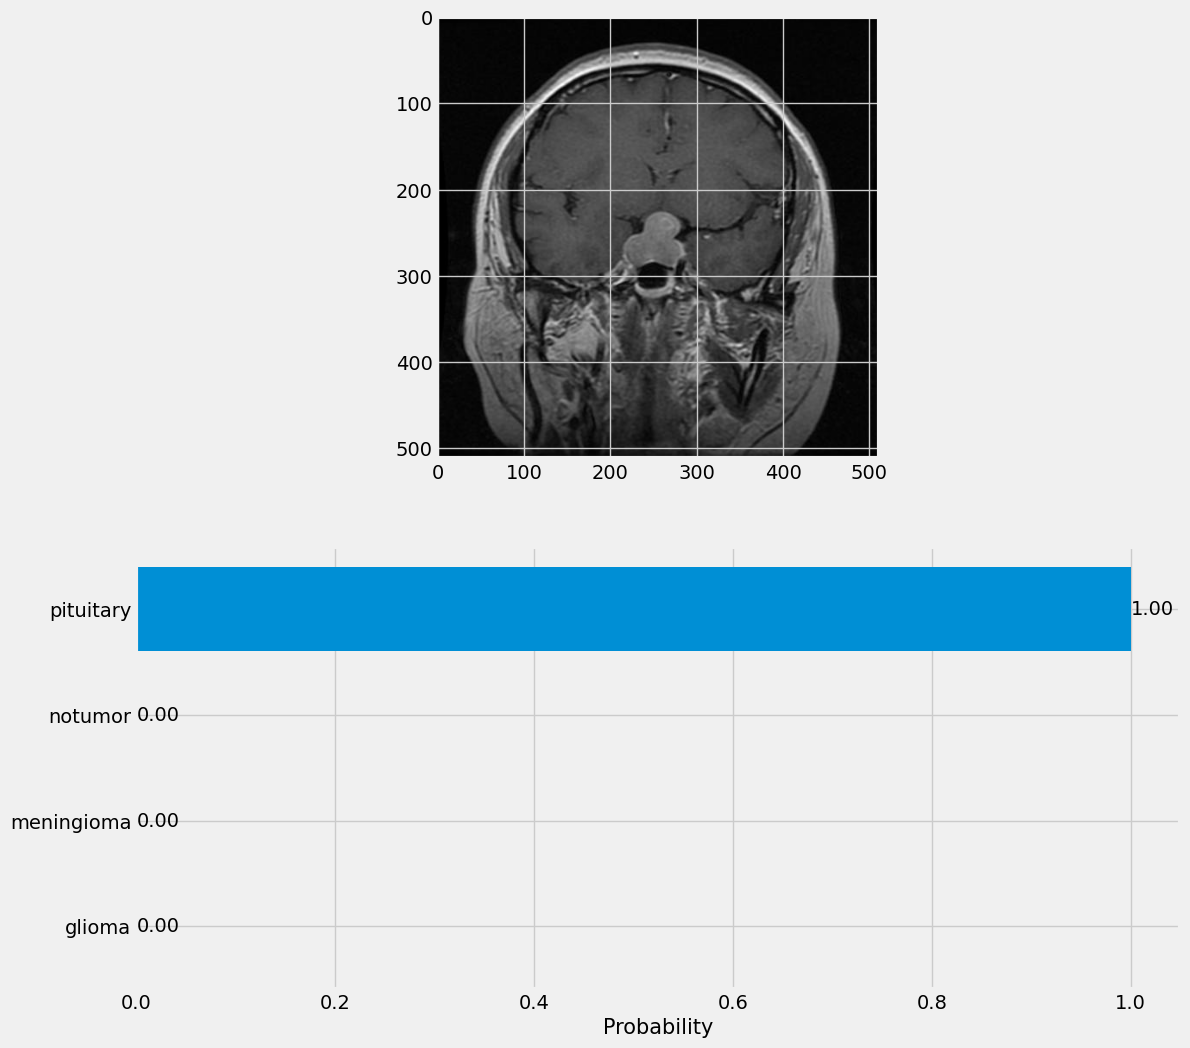

In [31]:
predict('/content/drive/MyDrive/BTC/Dataset/Testing/pituitary/Te-piTr_0001.jpg')

In [32]:
import sys

# Save model summary to a text file
with open('model_summary.txt', 'w') as f:
    # Redirect stdout to the text file
    sys.stdout = f
    # Print the model summary
    model.summary()
    # Reset stdout to the console
    sys.stdout = sys.__stdout__

print("Model summary saved as 'model_summary.txt'")

In [33]:
model.save('CNN.keras')